In [268]:
import jax.numpy as jnp
import jax
from jax import random

from flax import linen as nn
from einops import rearrange
import optax
import tensorflow as tf
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_probability.substrates.jax as tfp

# Ensure TF does not see GPU and grab all GPU memory
tf.config.experimental.set_visible_devices([], "GPU")

In [269]:
def get_mnist_dataset(split):
    """Returns a raw array of the MNIST dataset."""
    # Load the dataset
    ds = tfds.load('mnist', split=split, shuffle_files=True if split == "train" else False)

    # Define a function to preprocess each batch
    def preprocess(batch):
        images = batch['image']
        # Flatten the images and normalize their pixel values to [0, 1]
        images = tf.cast(images, tf.float32) / 255.
        labels = batch['label']
        return images, labels

    # Map the preprocessing function to each batch
    ds = ds.map(preprocess)
    
    # Convert the tf.data.Dataset into an iterable of NumPy arrays
    numpy_ds = tfds.as_numpy(ds)

    # Convert the iterable of NumPy arrays into a single NumPy array
    images, labels = zip(*list(numpy_ds))
    images = jnp.array(images)
    labels = jnp.array(labels)

    return images, labels

x, labels = get_mnist_dataset("train")

In [71]:
class MLP(nn.Module):
    """ A simple MLP in Flax. This is the score function.
    """
    hidden_dim: int = 256
    out_dim: int = 2
    n_layers: int = 4

    @nn.compact
    def __call__(self, x):
        for _ in range(self.n_layers):
            x = nn.Dense(features=self.hidden_dim)(x)
            x = nn.gelu(x)
        x = nn.Dense(features=self.out_dim)(x)
        return x


In [369]:
class VAE(nn.Module):
    """ A simple variational auto-encoder module.
    """
    num_latents: int = 4
    num_out: int = 2

    def setup(self):
        self.encoder = MLP(out_dim=self.num_latents * 2)
        self.decoder = MLP(out_dim=28 * 28)

    def __call__(self, x, beta, z_rng):

        # Flatten x
        x = rearrange(x, 'b h w c -> b (h w c)')

        # Concatenate x and beta
        x = jnp.concatenate([x, beta], axis=-1)

        # Get variational parameters from encoder
        enc = self.encoder(x)  # Shape (batch_size, num_latents * 2)
        enc = rearrange(enc, 'b (n c) -> b n c', c=2)  # Reshape to (batch_size, num_latents, 2)
        mu, logvar = enc[:, :, 0], enc[:, :, 1]

        # Sample from variational distrib. of latents
        z = tfp.distributions.Normal(loc=mu, scale=jnp.exp(0.5 * logvar)).sample(seed=z_rng)

        # Concatenate z and beta
        z = jnp.concatenate([z, beta], axis=-1)
        
        # Decode
        recon_x = self.decoder(z)

        return recon_x, mu, logvar

@jax.vmap
def rate(mu, logvar):
    """ KL-divergence between latent variational distribution and unit Normal prior
    """
    prior_latent = tfp.distributions.Normal(loc=0., scale=1.)  # Prior
    q_latent = tfp.distributions.Normal(loc=mu, scale=jnp.exp(0.5 * logvar))  # Variational latent distrib.

    return tfp.distributions.kl_divergence(q_latent, prior_latent)

@jax.vmap
def distortion(pred, true, beta):
    """ Gaussian MSE
    """
    true = rearrange(true, 'h w c -> (h w c)')
    # Restrict between 0 and 1 with sigmoid
    pred = nn.sigmoid(pred)
    log_prob = tfp.distributions.Normal(loc=pred, scale=beta).unnormalized_log_prob(true)
    return -log_prob

from functools import partial

@partial(jax.jit, static_argnums=(1,))
def loss_fn(params, vae, x_batch, log_beta_batch, z_rng):

    beta_batch = jnp.power(10., log_beta_batch)
    
    recon_x, mean, logvar = vae.apply(params, x_batch, beta_batch, z_rng)

    R = rate(mean, logvar).mean(-1)
    D = distortion(recon_x, x_batch, beta_batch).mean(-1)

    loss = D + R
    return loss.mean()

In [370]:
num_latents = 64
num_out = 28 * 28

vae = VAE(num_latents=num_latents, num_out=num_out)
key = jax.random.PRNGKey(42)
key, z_key = random.split(key)
_, params = vae.init_with_output(key, x[:16], jnp.ones((16, 1)), z_key)

In [371]:
print(loss_fn(params, vae, x[:128], jnp.ones((128, 1)) * 2.,  key))

6.2491755


In [372]:
n_steps = 1000
n_batch = 512

opt = optax.adam(learning_rate=3e-4)
opt_state = opt.init(params)

with trange(n_steps) as steps:
    for step in steps:

        # Draw a random batches from x
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, x.shape[0], shape=(n_batch,))
        
        x_batch = x[idx]

        # Draw random batch of betas
        key, subkey = jax.random.split(key)
        log_beta_batch = jnp.ones((n_batch, 1)) * -1.

        # Get loss and update
        loss, grads = jax.value_and_grad(loss_fn)(params, vae, x_batch, log_beta_batch, key)
        updates, opt_state = opt.update(grads, opt_state, params)

        params = optax.apply_updates(params, updates)

        steps.set_postfix(val=loss)

100%|██████████| 1000/1000 [00:34<00:00, 28.70it/s, val=0.24463052]


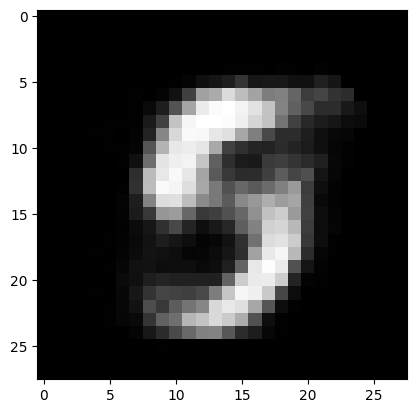

In [373]:
@jax.jit
def eval(params, z):
    def eval_model(vae):
        return vae.decoder(z)
    return nn.sigmoid(nn.apply(eval_model, vae)(params))

z = jax.random.normal(key, shape=(16, num_latents))
z = jnp.concatenate([z, jnp.zeros((16, 1))], axis=-1)
x_samples = eval(params, z)

# Make grid and plot x_samples
x_samples = rearrange(x_samples, 'b (h w c) -> b h w c', h=28, w=28, c=1)

plt.imshow(x_samples[6, :, :, 0], cmap='gray')

In [374]:
n_steps = 1000
n_batch = 512

opt = optax.adam(learning_rate=3e-4)
opt_state = opt.init(params)

with trange(n_steps) as steps:
    for step in steps:

        # Draw a random batches from x
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, x.shape[0], shape=(n_batch,))
        
        x_batch = x[idx]

        # Draw random batch of betas
        key, subkey = jax.random.split(key)
        log_beta_batch = jax.random.uniform(key, shape=(n_batch, 1), minval=-2., maxval=1)

        # Get loss and update
        loss, grads = jax.value_and_grad(loss_fn)(params, vae, x_batch, log_beta_batch, key)
        updates, opt_state = opt.update(grads, opt_state, params)

        params = optax.apply_updates(params, updates)

        steps.set_postfix(val=loss)

100%|██████████| 1000/1000 [00:35<00:00, 27.82it/s, val=7.333931] 


Text(0.5, 0, 'Distortion')

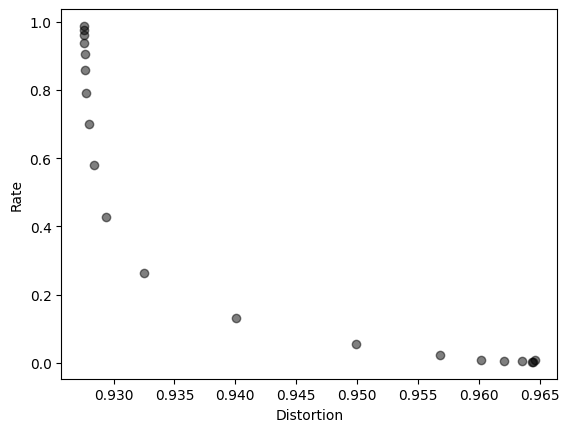

In [401]:
@jax.jit
def get_RD(params, x, beta, key):
    x = rearrange(x, 'b h w c -> b (h w c)')
    x = jnp.concatenate([x, beta], axis=-1)
    def encode_decode_model(vae):
        enc = vae.encoder(x)
        enc = rearrange(enc, 'b (n c) -> b n c', c=2)
        mu, logvar = enc[:, :, 0], enc[:, :, 1]
        R = rate(mu, logvar)
        z = tfp.distributions.Normal(loc=mu, scale=jnp.exp(0.5 * logvar)).sample(seed=key)
        z = jnp.concatenate([z, beta], axis=-1)
        return vae.decoder(z), R
    
    reco, R = nn.apply(encode_decode_model, vae)(params)
    x = rearrange(x[..., :-1], 'b (h w c) -> b h w c', h=28, w=28, c=1)
    D = distortion(reco, x, jnp.ones_like(beta))
    return R.mean(-1).mean(), D.mean(-1).mean(), reco

ii = 40

log_beta_ary = jnp.linspace(-2., 1, 20)

n_agg = 16

reco_list = []
for log_beta in log_beta_ary:
    beta = jnp.ones((n_agg, 1)) * 10 ** log_beta
    R, D, reco = get_RD(params, x[ii:ii + n_agg], beta, key)
    plt.scatter(D, R, alpha=0.5, color='k')
    reco = nn.sigmoid(rearrange(reco, 'b (h w c) -> b h w c', h=28, w=28, c=1))
    reco_list.append(reco)

plt.ylabel('Rate')
plt.xlabel('Distortion')

(20, 16, 28, 28, 1)

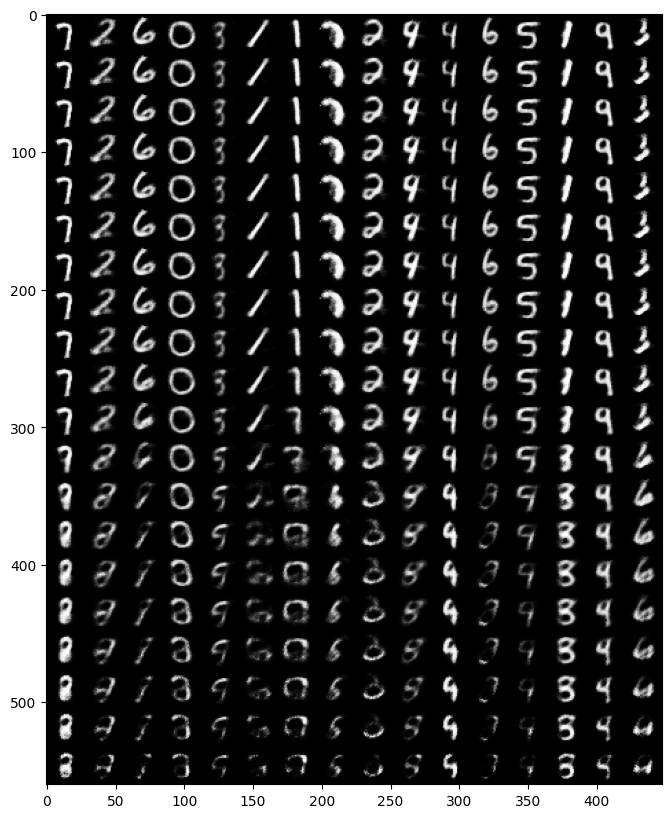

In [404]:
reco_list = jnp.array(reco_list)

x_samples = rearrange(reco_list, "n1 n2 h w 1 -> (n1 h) (n2 w)")

plt.figure(figsize=(10, 10))
plt.imshow(x_samples, cmap='gray')

reco_list.shape